# Data Collection & Preparation using Yelp API

* Author: Kiran Kulkarni

### Task 1: Data Identification

The API chosen is a Developers API provided by Yelp. 

API URL: https://api.yelp.com/v3/businesses/search

End Point: This endpoint returns detailed business content. Normally, you would get the Business ID from /businesses/search, /businesses/search/phone, /transactions/{transaction_type}/search or /autocomplete. To retrieve review excerpts for a business, please refer to our Reviews endpoint (/businesses/{id}/reviews).

### Task 2: Data Collection

To request the data from API I have made use of 'requests' package. To handle the JSON data, 'json' package is used.
'pandas' used for data transformation and analysis.

'bokeh' is used for visualixations

In [1]:
#import the necessary libraries.

import requests as rq
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sn

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
from bokeh.models import HoverTool
from bokeh.models import CategoricalColorMapper

output_notebook()

Loading BokehJS ...

Here I am trying to query the API end point to provide the data for places that are open now and serve food at the New york City.
Since the API limits the data to 50 records per request, I am trying to make multiple requests to API to gather a considerable amount of data.

In [2]:
#base URL
url = "https://api.yelp.com/v3/businesses/search"

#API key, can be obtained from the website.
api_key = "Your Own API Key"

#Authorization
headers = { "Authorization": "Bearer " + api_key }

biz = []

for i in range(0, 1000, 50):
    #passing the parameters to the API.
    params = {"term":"food","location": "NYC", "open_now": True, "limit": 50,"offset": i, 
          'businesses[x].transactions': ['pickup', 'delivery', 'restaurant_reservation']}
    response = rq.get(url, headers = headers, params = params)
    if response.reason == 'OK':
        biz += response.json()["businesses"]
    else: 
        print(response.reason)

In [3]:
#Dump the requested JSOn into a variable.
content = json.dumps(biz, indent=4)

#Write the dumped content into a JSON file.
file = open('./yelpBusiness.json', 'w')
file.writelines(content)
file.close()

In [4]:
#Import the raw data from JSOn file.
df_raw = pd.read_json('yelpBusiness.json')

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
id               1000 non-null object
alias            1000 non-null object
name             1000 non-null object
image_url        1000 non-null object
is_closed        1000 non-null bool
url              1000 non-null object
review_count     1000 non-null int64
categories       1000 non-null object
rating           1000 non-null float64
coordinates      1000 non-null object
transactions     1000 non-null object
price            898 non-null object
location         1000 non-null object
phone            1000 non-null object
display_phone    1000 non-null object
distance         1000 non-null float64
dtypes: bool(1), float64(2), int64(1), object(12)
memory usage: 118.3+ KB


The main issue with the requested data is that, few columns contain values that needs to be falttened.

* categories - [{'alias': 'sportsbars', 'title': 'Sports Bars'}].
* coordinates - {'latitude': 40.764164, 'longitude': -73.98306}.
* transactions - {'address1': '236 W 54th St', 'address2': '', ...}]

To normalize the data, I have made use of different techniques. json_normalize() is a sub module used for normalizing the given data.

In [5]:
#To convert the str to json first.
df_cat_1 = df_raw['categories'].to_json(orient='values')

#To import the values as json.
df_cat_2 = pd.read_json(df_cat_1)

#To convert json into json as records.
df_cat_3 = df_cat_2[0].to_json(orient='records')

#Reading from the json.
df_cat = pd.read_json(df_cat_3)

#Selecting only the 'title' column and returning a pandas DataFrame.
df_categories = df_cat[['title']]

#To make sure, that the object is a DataFrame type
print(type(df_categories))

#Renaming the column to 'category'
df_categories.columns = ['category']

df_categories

<class 'pandas.core.frame.DataFrame'>


,category
0,Latin American
1,Vietnamese
2,Tacos
3,Tacos
4,Pizza
...,...
995,Japanese
996,Pizza
997,Cajun/Creole
998,American (New)


In [6]:
#Concatenate the normalized data into the raw data
df_raw = pd.concat([df_raw, df_categories], axis=1)

df_raw.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance,category
0,LvzN8TrUGJRj_UkJV0cAtQ,empanada-mama-hells-kitchen-new-york,Empanada Mama - Hell's Kitchen,https://s3-media1.fl.yelpcdn.com/bphoto/KskFKH...,False,https://www.yelp.com/biz/empanada-mama-hells-k...,2420,"[{'alias': 'latin', 'title': 'Latin American'}...",4.0,"{'latitude': 40.76441, 'longitude': -73.9885}","[delivery, pickup]",$,"{'address1': '765 9th Ave', 'address2': None, ...",+12126989008,(212) 698-9008,6577.483084,Latin American
1,C2o3Iw-DXjoUJFgQIbiqkQ,bocaphê-new-york-3,BoCaphe,https://s3-media4.fl.yelpcdn.com/bphoto/aH2xCJ...,False,https://www.yelp.com/biz/bocaph%C3%AA-new-york...,1511,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",4.0,"{'latitude': 40.722046, 'longitude': -73.997557}","[restaurant_reservation, delivery, pickup]",$$,"{'address1': '222 Lafayette St', 'address2': '...",+16468821939,(646) 882-1939,1866.343663,Vietnamese
2,jnEv25Y2DosTq2sNnvmC9g,los-tacos-no-1-new-york,Los Tacos No.1,https://s3-media2.fl.yelpcdn.com/bphoto/FU44TY...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,2950,"[{'alias': 'tacos', 'title': 'Tacos'}]",4.5,"{'latitude': 40.7425547, 'longitude': -74.0060...",[],$,"{'address1': '75 9th Ave', 'address2': '', 'ad...",+12122560343,(212) 256-0343,4244.358699,Tacos
3,SULHf6nGQ8sK0UpG1XU30w,los-tacos-no-1-new-york-3,Los Tacos No.1,https://s3-media4.fl.yelpcdn.com/bphoto/5wEe4F...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,1745,"[{'alias': 'tacos', 'title': 'Tacos'}]",4.5,"{'latitude': 40.7575067, 'longitude': -73.9877...",[],$,"{'address1': '229 W 43rd St', 'address2': '', ...",+12125744696,(212) 574-4696,5815.027424,Tacos
4,ysqgdbSrezXgVwER2kQWKA,julianas-pizza-brooklyn-5,Juliana's Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/clscwg...,False,https://www.yelp.com/biz/julianas-pizza-brookl...,2173,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.5,"{'latitude': 40.7026153030093, 'longitude': -7...",[],$$,"{'address1': '19 Old Fulton St', 'address2': '...",+17185966700,(718) 596-6700,323.205063,Pizza


In [7]:
# To split the co-ordinates into different columns lattitude and longitude.
df_co_ordinates = json_normalize(df_raw['coordinates'], sep='_')
df_co_ordinates.head()

,latitude,longitude
0,40.764410,-73.988500
1,40.722046,-73.997557
2,40.742555,-74.006084
3,40.757507,-73.987772
4,40.702615,-73.993416


In [8]:
#Concatenate the normalized data into the raw data
df_raw = pd.concat([df_raw, df_co_ordinates], axis=1)

df_raw.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance,category,latitude,longitude
0,LvzN8TrUGJRj_UkJV0cAtQ,empanada-mama-hells-kitchen-new-york,Empanada Mama - Hell's Kitchen,https://s3-media1.fl.yelpcdn.com/bphoto/KskFKH...,False,https://www.yelp.com/biz/empanada-mama-hells-k...,2420,"[{'alias': 'latin', 'title': 'Latin American'}...",4.0,"{'latitude': 40.76441, 'longitude': -73.9885}","[delivery, pickup]",$,"{'address1': '765 9th Ave', 'address2': None, ...",+12126989008,(212) 698-9008,6577.483084,Latin American,40.764410,-73.988500
1,C2o3Iw-DXjoUJFgQIbiqkQ,bocaphê-new-york-3,BoCaphe,https://s3-media4.fl.yelpcdn.com/bphoto/aH2xCJ...,False,https://www.yelp.com/biz/bocaph%C3%AA-new-york...,1511,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",4.0,"{'latitude': 40.722046, 'longitude': -73.997557}","[restaurant_reservation, delivery, pickup]",$$,"{'address1': '222 Lafayette St', 'address2': '...",+16468821939,(646) 882-1939,1866.343663,Vietnamese,40.722046,-73.997557
2,jnEv25Y2DosTq2sNnvmC9g,los-tacos-no-1-new-york,Los Tacos No.1,https://s3-media2.fl.yelpcdn.com/bphoto/FU44TY...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,2950,"[{'alias': 'tacos', 'title': 'Tacos'}]",4.5,"{'latitude': 40.7425547, 'longitude': -74.0060...",[],$,"{'address1': '75 9th Ave', 'address2': '', 'ad...",+12122560343,(212) 256-0343,4244.358699,Tacos,40.742555,-74.006084
3,SULHf6nGQ8sK0UpG1XU30w,los-tacos-no-1-new-york-3,Los Tacos No.1,https://s3-media4.fl.yelpcdn.com/bphoto/5wEe4F...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,1745,"[{'alias': 'tacos', 'title': 'Tacos'}]",4.5,"{'latitude': 40.7575067, 'longitude': -73.9877...",[],$,"{'address1': '229 W 43rd St', 'address2': '', ...",+12125744696,(212) 574-4696,5815.027424,Tacos,40.757507,-73.987772
4,ysqgdbSrezXgVwER2kQWKA,julianas-pizza-brooklyn-5,Juliana's Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/clscwg...,False,https://www.yelp.com/biz/julianas-pizza-brookl...,2173,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.5,"{'latitude': 40.7026153030093, 'longitude': -7...",[],$$,"{'address1': '19 Old Fulton St', 'address2': '...",+17185966700,(718) 596-6700,323.205063,Pizza,40.702615,-73.993416


In [9]:
#Extracting only the records with values.
df_transactions = df_raw['transactions'].to_json(orient = 'records')

df_transactions = pd.read_json(df_transactions)

#renaming the column names
df_transactions.columns = ['is_pickup', 'is_delivery', 'is_restaurant_reservation']

df_transactions.head()

,is_pickup,is_delivery,is_restaurant_reservation
0,delivery,pickup,None
1,restaurant_reservation,delivery,pickup
2,None,None,None
3,None,None,None
4,None,None,None


In [10]:
#Concatenate the normalized data into the raw data
df_raw = pd.concat([df_raw, df_transactions], axis=1)
df_raw.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,...,location,phone,display_phone,distance,category,latitude,longitude,is_pickup,is_delivery,is_restaurant_reservation
0,LvzN8TrUGJRj_UkJV0cAtQ,empanada-mama-hells-kitchen-new-york,Empanada Mama - Hell's Kitchen,https://s3-media1.fl.yelpcdn.com/bphoto/KskFKH...,False,https://www.yelp.com/biz/empanada-mama-hells-k...,2420,"[{'alias': 'latin', 'title': 'Latin American'}...",4.0,"{'latitude': 40.76441, 'longitude': -73.9885}",...,"{'address1': '765 9th Ave', 'address2': None, ...",+12126989008,(212) 698-9008,6577.483084,Latin American,40.764410,-73.988500,delivery,pickup,None
1,C2o3Iw-DXjoUJFgQIbiqkQ,bocaphê-new-york-3,BoCaphe,https://s3-media4.fl.yelpcdn.com/bphoto/aH2xCJ...,False,https://www.yelp.com/biz/bocaph%C3%AA-new-york...,1511,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",4.0,"{'latitude': 40.722046, 'longitude': -73.997557}",...,"{'address1': '222 Lafayette St', 'address2': '...",+16468821939,(646) 882-1939,1866.343663,Vietnamese,40.722046,-73.997557,restaurant_reservation,delivery,pickup
2,jnEv25Y2DosTq2sNnvmC9g,los-tacos-no-1-new-york,Los Tacos No.1,https://s3-media2.fl.yelpcdn.com/bphoto/FU44TY...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,2950,"[{'alias': 'tacos', 'title': 'Tacos'}]",4.5,"{'latitude': 40.7425547, 'longitude': -74.0060...",...,"{'address1': '75 9th Ave', 'address2': '', 'ad...",+12122560343,(212) 256-0343,4244.358699,Tacos,40.742555,-74.006084,None,None,None
3,SULHf6nGQ8sK0UpG1XU30w,los-tacos-no-1-new-york-3,Los Tacos No.1,https://s3-media4.fl.yelpcdn.com/bphoto/5wEe4F...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,1745,"[{'alias': 'tacos', 'title': 'Tacos'}]",4.5,"{'latitude': 40.7575067, 'longitude': -73.9877...",...,"{'address1': '229 W 43rd St', 'address2': '', ...",+12125744696,(212) 574-4696,5815.027424,Tacos,40.757507,-73.987772,None,None,None
4,ysqgdbSrezXgVwER2kQWKA,julianas-pizza-brooklyn-5,Juliana's Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/clscwg...,False,https://www.yelp.com/biz/julianas-pizza-brookl...,2173,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.5,"{'latitude': 40.7026153030093, 'longitude': -7...",...,"{'address1': '19 Old Fulton St', 'address2': '...",+17185966700,(718) 596-6700,323.205063,Pizza,40.702615,-73.993416,None,None,None


In [11]:
#Concatenate the normalized data into the raw data
df_location = json_normalize(df_raw['location'], sep='_')
df_location.head()

,address1,address2,address3,city,zip_code,country,state,display_address
0,765 9th Ave,None,,New York,10019,US,NY,"[765 9th Ave, New York, NY 10019]"
1,222 Lafayette St,,,New York,10012,US,NY,"[222 Lafayette St, New York, NY 10012]"
2,75 9th Ave,,,New York,10011,US,NY,"[75 9th Ave, New York, NY 10011]"
3,229 W 43rd St,,None,New York,10036,US,NY,"[229 W 43rd St, New York, NY 10036]"
4,19 Old Fulton St,,,Brooklyn,11201,US,NY,"[19 Old Fulton St, Brooklyn, NY 11201]"


In [12]:
df_raw = pd.concat([df_raw, df_location], axis=1)
df_raw

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,...,is_delivery,is_restaurant_reservation,address1,address2,address3,city,zip_code,country,state,display_address
0,LvzN8TrUGJRj_UkJV0cAtQ,empanada-mama-hells-kitchen-new-york,Empanada Mama - Hell's Kitchen,https://s3-media1.fl.yelpcdn.com/bphoto/KskFKH...,False,https://www.yelp.com/biz/empanada-mama-hells-k...,2420,"[{'alias': 'latin', 'title': 'Latin American'}...",4.0,"{'latitude': 40.76441, 'longitude': -73.9885}",...,pickup,None,765 9th Ave,None,,New York,10019,US,NY,"[765 9th Ave, New York, NY 10019]"
1,C2o3Iw-DXjoUJFgQIbiqkQ,bocaphê-new-york-3,BoCaphe,https://s3-media4.fl.yelpcdn.com/bphoto/aH2xCJ...,False,https://www.yelp.com/biz/bocaph%C3%AA-new-york...,1511,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",4.0,"{'latitude': 40.722046, 'longitude': -73.997557}",...,delivery,pickup,222 Lafayette St,,,New York,10012,US,NY,"[222 Lafayette St, New York, NY 10012]"
2,jnEv25Y2DosTq2sNnvmC9g,los-tacos-no-1-new-york,Los Tacos No.1,https://s3-media2.fl.yelpcdn.com/bphoto/FU44TY...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,2950,"[{'alias': 'tacos', 'title': 'Tacos'}]",4.5,"{'latitude': 40.7425547, 'longitude': -74.0060...",...,None,None,75 9th Ave,,,New York,10011,US,NY,"[75 9th Ave, New York, NY 10011]"
3,SULHf6nGQ8sK0UpG1XU30w,los-tacos-no-1-new-york-3,Los Tacos No.1,https://s3-media4.fl.yelpcdn.com/bphoto/5wEe4F...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,1745,"[{'alias': 'tacos', 'title': 'Tacos'}]",4.5,"{'latitude': 40.7575067, 'longitude': -73.9877...",...,None,None,229 W 43rd St,,None,New York,10036,US,NY,"[229 W 43rd St, New York, NY 10036]"
4,ysqgdbSrezXgVwER2kQWKA,julianas-pizza-brooklyn-5,Juliana's Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/clscwg...,False,https://www.yelp.com/biz/julianas-pizza-brookl...,2173,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.5,"{'latitude': 40.7026153030093, 'longitude': -7...",...,None,None,19 Old Fulton St,,,Brooklyn,11201,US,NY,"[19 Old Fulton St, Brooklyn, NY 11201]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,ZaJS8EKQNSaQpwpmgN-vVw,samurai-mama-brooklyn,Samurai Mama,https://s3-media1.fl.yelpcdn.com/bphoto/iU4mCy...,False,https://www.yelp.com/biz/samurai-mama-brooklyn...,592,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",4.0,"{'latitude': 40.7140208838114, 'longitude': -7...",...,None,None,205 Grand St,,,Brooklyn,11211,US,NY,"[205 Grand St, Brooklyn, NY 11211]"
996,0UdC0VYX6aAvLiOcpR4MVQ,joes-pizza-new-york-7,Joe's Pizza,https://s3-media3.fl.yelpcdn.com/bphoto/BTCcvl...,False,https://www.yelp.com/biz/joes-pizza-new-york-7...,886,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.0,"{'latitude': 40.73331, 'longitude': -73.98763}",...,delivery,None,150 E 14th St,,,New York,10003,US,NY,"[150 E 14th St, New York, NY 10003]"
997,mmFEdsr3os5z86aVP7tW0w,tchoup-shop-brooklyn,Tchoup Shop,https://s3-media1.fl.yelpcdn.com/bphoto/yjNMYK...,False,https://www.yelp.com/biz/tchoup-shop-brooklyn?...,226,"[{'alias': 'cajun', 'title': 'Cajun/Creole'}, ...",4.0,"{'latitude': 40.70565, 'longitude': -73.92161}",...,delivery,None,50 Wyckoff Ave,,,Brooklyn,11237,US,NY,"[50 Wyckoff Ave, Brooklyn, NY 11237]"
998,YSflX6shqcP3zYno0Zz75Q,while-we-were-young-new-york,While We Were Young,https://s3-media3.fl.yelpcdn.com/bphoto/P_eUz_...,False,https://www.yelp.com/biz/while-we-were-young-n...,340,"[{'alias': 'newamerican', 'title': 'American (...",4.0,"{'latitude': 40.73437, 'longitude': -74.00272}",...,None,None,183 W 10th St,None,,New York,10014,US,NY,"[183 W 10th St, New York, NY 10014]"


In [13]:
df_raw = df_raw.drop(columns = ['categories', 'coordinates', 'transactions', 'location'])

df_raw

,id,alias,name,image_url,is_closed,url,review_count,rating,price,phone,...,is_delivery,is_restaurant_reservation,address1,address2,address3,city,zip_code,country,state,display_address
0,LvzN8TrUGJRj_UkJV0cAtQ,empanada-mama-hells-kitchen-new-york,Empanada Mama - Hell's Kitchen,https://s3-media1.fl.yelpcdn.com/bphoto/KskFKH...,False,https://www.yelp.com/biz/empanada-mama-hells-k...,2420,4.0,$,+12126989008,...,pickup,None,765 9th Ave,None,,New York,10019,US,NY,"[765 9th Ave, New York, NY 10019]"
1,C2o3Iw-DXjoUJFgQIbiqkQ,bocaphê-new-york-3,BoCaphe,https://s3-media4.fl.yelpcdn.com/bphoto/aH2xCJ...,False,https://www.yelp.com/biz/bocaph%C3%AA-new-york...,1511,4.0,$$,+16468821939,...,delivery,pickup,222 Lafayette St,,,New York,10012,US,NY,"[222 Lafayette St, New York, NY 10012]"
2,jnEv25Y2DosTq2sNnvmC9g,los-tacos-no-1-new-york,Los Tacos No.1,https://s3-media2.fl.yelpcdn.com/bphoto/FU44TY...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,2950,4.5,$,+12122560343,...,None,None,75 9th Ave,,,New York,10011,US,NY,"[75 9th Ave, New York, NY 10011]"
3,SULHf6nGQ8sK0UpG1XU30w,los-tacos-no-1-new-york-3,Los Tacos No.1,https://s3-media4.fl.yelpcdn.com/bphoto/5wEe4F...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,1745,4.5,$,+12125744696,...,None,None,229 W 43rd St,,None,New York,10036,US,NY,"[229 W 43rd St, New York, NY 10036]"
4,ysqgdbSrezXgVwER2kQWKA,julianas-pizza-brooklyn-5,Juliana's Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/clscwg...,False,https://www.yelp.com/biz/julianas-pizza-brookl...,2173,4.5,$$,+17185966700,...,None,None,19 Old Fulton St,,,Brooklyn,11201,US,NY,"[19 Old Fulton St, Brooklyn, NY 11201]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,ZaJS8EKQNSaQpwpmgN-vVw,samurai-mama-brooklyn,Samurai Mama,https://s3-media1.fl.yelpcdn.com/bphoto/iU4mCy...,False,https://www.yelp.com/biz/samurai-mama-brooklyn...,592,4.0,$$,+17185996161,...,None,None,205 Grand St,,,Brooklyn,11211,US,NY,"[205 Grand St, Brooklyn, NY 11211]"
996,0UdC0VYX6aAvLiOcpR4MVQ,joes-pizza-new-york-7,Joe's Pizza,https://s3-media3.fl.yelpcdn.com/bphoto/BTCcvl...,False,https://www.yelp.com/biz/joes-pizza-new-york-7...,886,4.0,$,+12123889474,...,delivery,None,150 E 14th St,,,New York,10003,US,NY,"[150 E 14th St, New York, NY 10003]"
997,mmFEdsr3os5z86aVP7tW0w,tchoup-shop-brooklyn,Tchoup Shop,https://s3-media1.fl.yelpcdn.com/bphoto/yjNMYK...,False,https://www.yelp.com/biz/tchoup-shop-brooklyn?...,226,4.0,$$,+19292343500,...,delivery,None,50 Wyckoff Ave,,,Brooklyn,11237,US,NY,"[50 Wyckoff Ave, Brooklyn, NY 11237]"
998,YSflX6shqcP3zYno0Zz75Q,while-we-were-young-new-york,While We Were Young,https://s3-media3.fl.yelpcdn.com/bphoto/P_eUz_...,False,https://www.yelp.com/biz/while-we-were-young-n...,340,4.0,$$,+19176756272,...,None,None,183 W 10th St,None,,New York,10014,US,NY,"[183 W 10th St, New York, NY 10014]"


In [14]:
df_raw.to_json('./yelp_business_clean.json', orient='records')

This ends the Data Collection and Storing part.

### Task 3: Data Preparation and Analysis

The initial analysis involves looking at the statistical summary, data information and data types. 

In [15]:
#Read the data from clean json file and import it to a pandas DataFrame.
df_clean = pd.read_json('yelp_business_clean.json')

df_clean.head()

,id,alias,name,image_url,is_closed,url,review_count,rating,price,phone,...,is_delivery,is_restaurant_reservation,address1,address2,address3,city,zip_code,country,state,display_address
0,LvzN8TrUGJRj_UkJV0cAtQ,empanada-mama-hells-kitchen-new-york,Empanada Mama - Hell's Kitchen,https://s3-media1.fl.yelpcdn.com/bphoto/KskFKH...,False,https://www.yelp.com/biz/empanada-mama-hells-k...,2420,4.0,$,+12126989008,...,pickup,None,765 9th Ave,None,,New York,10019,US,NY,"[765 9th Ave, New York, NY 10019]"
1,C2o3Iw-DXjoUJFgQIbiqkQ,bocaphê-new-york-3,BoCaphe,https://s3-media4.fl.yelpcdn.com/bphoto/aH2xCJ...,False,https://www.yelp.com/biz/bocaph%C3%AA-new-york...,1511,4.0,$$,+16468821939,...,delivery,pickup,222 Lafayette St,,,New York,10012,US,NY,"[222 Lafayette St, New York, NY 10012]"
2,jnEv25Y2DosTq2sNnvmC9g,los-tacos-no-1-new-york,Los Tacos No.1,https://s3-media2.fl.yelpcdn.com/bphoto/FU44TY...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,2950,4.5,$,+12122560343,...,None,None,75 9th Ave,,,New York,10011,US,NY,"[75 9th Ave, New York, NY 10011]"
3,SULHf6nGQ8sK0UpG1XU30w,los-tacos-no-1-new-york-3,Los Tacos No.1,https://s3-media4.fl.yelpcdn.com/bphoto/5wEe4F...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,1745,4.5,$,+12125744696,...,None,None,229 W 43rd St,,None,New York,10036,US,NY,"[229 W 43rd St, New York, NY 10036]"
4,ysqgdbSrezXgVwER2kQWKA,julianas-pizza-brooklyn-5,Juliana's Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/clscwg...,False,https://www.yelp.com/biz/julianas-pizza-brookl...,2173,4.5,$$,+17185966700,...,None,None,19 Old Fulton St,,,Brooklyn,11201,US,NY,"[19 Old Fulton St, Brooklyn, NY 11201]"


In [16]:
# Storing the file into a csv file
df_clean.to_csv('yelp_clean.csv')

In [17]:
#Check the type of the df_clean
type(df_clean)

pandas.core.frame.DataFrame

In [18]:
# To check the number of records.
df_clean.shape

(1000, 26)

In [19]:
#looking at the data types.
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
id                           1000 non-null object
alias                        1000 non-null object
name                         1000 non-null object
image_url                    1000 non-null object
is_closed                    1000 non-null bool
url                          1000 non-null object
review_count                 1000 non-null int64
rating                       1000 non-null float64
price                        898 non-null object
phone                        1000 non-null object
display_phone                1000 non-null object
distance                     1000 non-null float64
category                     1000 non-null object
latitude                     1000 non-null float64
longitude                    1000 non-null float64
is_pickup                    745 non-null object
is_delivery                  696 non-null object
is_restaurant_reservation    69 non-null objec

In [20]:
#Summary statistics
df_clean.describe()

,review_count,rating,distance,latitude,longitude,zip_code
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,512.723000,4.154000,5554.741768,40.727909,-73.966822,10535.875000
std,872.735196,0.339705,4117.609942,0.044655,0.040252,667.519561
min,2.000000,2.500000,219.322908,40.572994,-74.155344,7020.000000
25%,118.000000,4.000000,2628.177581,40.702759,-73.991803,10013.000000
50%,261.000000,4.000000,4564.002502,40.726137,-73.979858,10038.000000
75%,590.500000,4.500000,7394.439397,40.754474,-73.950622,11215.000000
max,12203.000000,5.000000,43303.726211,41.001920,-73.660440,11694.000000


In [21]:
#look for missing data
df_clean.isnull().sum() # no missing values in the reduced dataset 

id                             0
alias                          0
name                           0
image_url                      0
is_closed                      0
url                            0
review_count                   0
rating                         0
price                        102
phone                          0
display_phone                  0
distance                       0
category                       0
latitude                       0
longitude                      0
is_pickup                    255
is_delivery                  304
is_restaurant_reservation    931
address1                       0
address2                     284
address3                     261
city                           0
zip_code                       0
country                        0
state                          0
display_address                0
dtype: int64

In [22]:
df_clean = df_clean.fillna(value = np.nan)
df_clean

,id,alias,name,image_url,is_closed,url,review_count,rating,price,phone,...,is_delivery,is_restaurant_reservation,address1,address2,address3,city,zip_code,country,state,display_address
0,LvzN8TrUGJRj_UkJV0cAtQ,empanada-mama-hells-kitchen-new-york,Empanada Mama - Hell's Kitchen,https://s3-media1.fl.yelpcdn.com/bphoto/KskFKH...,False,https://www.yelp.com/biz/empanada-mama-hells-k...,2420,4.0,$,+12126989008,...,pickup,NaN,765 9th Ave,NaN,,New York,10019,US,NY,"[765 9th Ave, New York, NY 10019]"
1,C2o3Iw-DXjoUJFgQIbiqkQ,bocaphê-new-york-3,BoCaphe,https://s3-media4.fl.yelpcdn.com/bphoto/aH2xCJ...,False,https://www.yelp.com/biz/bocaph%C3%AA-new-york...,1511,4.0,$$,+16468821939,...,delivery,pickup,222 Lafayette St,,,New York,10012,US,NY,"[222 Lafayette St, New York, NY 10012]"
2,jnEv25Y2DosTq2sNnvmC9g,los-tacos-no-1-new-york,Los Tacos No.1,https://s3-media2.fl.yelpcdn.com/bphoto/FU44TY...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,2950,4.5,$,+12122560343,...,NaN,NaN,75 9th Ave,,,New York,10011,US,NY,"[75 9th Ave, New York, NY 10011]"
3,SULHf6nGQ8sK0UpG1XU30w,los-tacos-no-1-new-york-3,Los Tacos No.1,https://s3-media4.fl.yelpcdn.com/bphoto/5wEe4F...,False,https://www.yelp.com/biz/los-tacos-no-1-new-yo...,1745,4.5,$,+12125744696,...,NaN,NaN,229 W 43rd St,,NaN,New York,10036,US,NY,"[229 W 43rd St, New York, NY 10036]"
4,ysqgdbSrezXgVwER2kQWKA,julianas-pizza-brooklyn-5,Juliana's Pizza,https://s3-media2.fl.yelpcdn.com/bphoto/clscwg...,False,https://www.yelp.com/biz/julianas-pizza-brookl...,2173,4.5,$$,+17185966700,...,NaN,NaN,19 Old Fulton St,,,Brooklyn,11201,US,NY,"[19 Old Fulton St, Brooklyn, NY 11201]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,ZaJS8EKQNSaQpwpmgN-vVw,samurai-mama-brooklyn,Samurai Mama,https://s3-media1.fl.yelpcdn.com/bphoto/iU4mCy...,False,https://www.yelp.com/biz/samurai-mama-brooklyn...,592,4.0,$$,+17185996161,...,NaN,NaN,205 Grand St,,,Brooklyn,11211,US,NY,"[205 Grand St, Brooklyn, NY 11211]"
996,0UdC0VYX6aAvLiOcpR4MVQ,joes-pizza-new-york-7,Joe's Pizza,https://s3-media3.fl.yelpcdn.com/bphoto/BTCcvl...,False,https://www.yelp.com/biz/joes-pizza-new-york-7...,886,4.0,$,+12123889474,...,delivery,NaN,150 E 14th St,,,New York,10003,US,NY,"[150 E 14th St, New York, NY 10003]"
997,mmFEdsr3os5z86aVP7tW0w,tchoup-shop-brooklyn,Tchoup Shop,https://s3-media1.fl.yelpcdn.com/bphoto/yjNMYK...,False,https://www.yelp.com/biz/tchoup-shop-brooklyn?...,226,4.0,$$,+19292343500,...,delivery,NaN,50 Wyckoff Ave,,,Brooklyn,11237,US,NY,"[50 Wyckoff Ave, Brooklyn, NY 11237]"
998,YSflX6shqcP3zYno0Zz75Q,while-we-were-young-new-york,While We Were Young,https://s3-media3.fl.yelpcdn.com/bphoto/P_eUz_...,False,https://www.yelp.com/biz/while-we-were-young-n...,340,4.0,$$,+19176756272,...,NaN,NaN,183 W 10th St,NaN,,New York,10014,US,NY,"[183 W 10th St, New York, NY 10014]"


#### Graph 1: How rating of all the restaurants distributed?

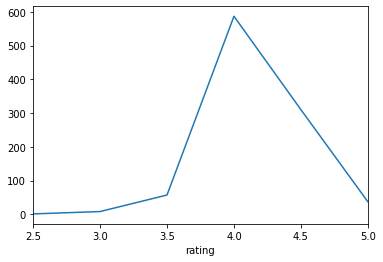

In [23]:
df_clean.groupby('rating').id.count().plot()

##### Insights: 
* By looking at the distribution, there are very less number of restaurants that have rating less than 3.5.
* Almost half of the restaurants that are open now, have the rating 4 and above.

#### Graph 2: What are the Top 10 categories of food that are served now?

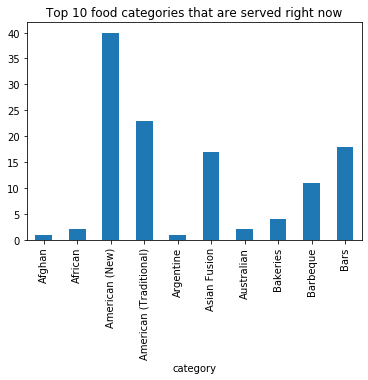

In [24]:
df_clean.groupby('category').id.count().head(10).plot(kind='bar', title = 'Top 10 food categories that are served right now')

#df_c

##### Insights:

* By looking at the graph, American style is the top category that is open. 
* Asian and Bakeries are the next category after American.

In [25]:
df_clean.dtypes

id                            object
alias                         object
name                          object
image_url                     object
is_closed                       bool
url                           object
review_count                   int64
rating                       float64
price                         object
phone                         object
display_phone                 object
distance                     float64
category                      object
latitude                     float64
longitude                    float64
is_pickup                     object
is_delivery                   object
is_restaurant_reservation     object
address1                      object
address2                      object
address3                      object
city                          object
zip_code                       int64
country                       object
state                         object
display_address               object
dtype: object

#### Graph 3: Which restaurants are delivering Indian food right now?

In [26]:
df_indian_delivery = df_clean[(df_clean['category']=='Indian') & (df_clean['is_delivery']=='delivery')]

df_indian_delivery.sample()

#df_indian_delivery.longitude.min()
#df_indian_delivery.latitude


,id,alias,name,image_url,is_closed,url,review_count,rating,price,phone,...,is_delivery,is_restaurant_reservation,address1,address2,address3,city,zip_code,country,state,display_address
232,GNPne4Il-itbn2sLbvMo1g,angel-indian-restaurant-jackson-heights,Angel Indian Restaurant,https://s3-media1.fl.yelpcdn.com/bphoto/8HFC6t...,False,https://www.yelp.com/biz/angel-indian-restaura...,68,5.0,$$,+13478480097,...,delivery,restaurant_reservation,7414 37th Rd,,NaN,Jackson Heights,11372,US,NY,"[7414 37th Rd, Jackson Heights, NY 11372]"


In [27]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap

df_indian_delivery = df_clean[(df_clean['category']=='Indian') & (df_clean['is_delivery']=='delivery')]

output_file("gmap2.html")

map_options = GMapOptions(lat=df_indian_delivery.latitude.mean(), lng=df_indian_delivery.longitude.mean(), map_type="roadmap", zoom=11)

# For GMaps to function, Google requires you obtain and enable an API key:
#
#     https://developers.google.com/maps/documentation/javascript/get-api-key
#
# Replace the value below with your personal API key:

#This Google Maps API key doesn't come with a Premium plan. It is just used to display the locations on the Map.
p = gmap("Request for your own API key", map_options, title="NYC Indian Restaurants delivering now.")

source = ColumnDataSource(
    data=dict(lat=df_indian_delivery.latitude,
              lon=df_indian_delivery.longitude)
)

p.circle(x="lon", y="lat", size=15, fill_color="blue", fill_alpha=0.8, source=source)

show(p)

#### Graph 4: What are Top 10 categories of food based on the 

In [28]:

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral6
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

top_10_category = df_clean.groupby('category').review_count.mean().reset_index().sort_values(by=['review_count'], ascending=False).head(10)

top_10_category

p = figure(x_axis_label = 'Top Categories', y_axis_label='Mean Review Count', 
           plot_height=450,plot_width=650, toolbar_location=None, title="Top 10 Categories based on the review count", x_range = top_10_category['category'])

p.vbar(x = top_10_category['category'], 
       top = top_10_category['review_count'],
       width=0.9)


show(p)

##### Insight:

* Tapas bars is the top category with more than 2000 reviews.
* Whereas, Belgian is last category amonf the top 10 categories.

##### Graph 5: What are the Vegan restaurants serving now that have review count above 50 and rating above 4?

In [30]:
df_clean['category'].unique()

array(['Latin American', 'Vietnamese', 'Tacos', 'Pizza', 'Southern',
       'Chicken Wings', 'Asian Fusion', 'Sandwiches', 'Food Court',
       'Food Stands', 'Ethiopian', 'Mexican', 'Chinese', 'Korean',
       'Burgers', 'Sushi Bars', 'Seafood', 'Fast Food', 'Chicken Shop',
       'Portuguese', 'American (New)', 'Food Trucks', 'Malaysian', 'Thai',
       'Halal', 'Desserts', 'American (Traditional)',
       'Tapas/Small Plates', 'Buffets', 'Cajun/Creole',
       'New Mexican Cuisine', 'Barbeque', 'Coffee & Tea',
       'Middle Eastern', 'Lebanese', 'Shanghainese', 'Teppanyaki',
       'Caribbean', 'Ramen', 'Japanese', 'Japanese Curry', 'Taiwanese',
       'Bubble Tea', 'Vegetarian', 'Hong Kong Style Cafe',
       'Modern European', 'Comfort Food', 'Australian', 'Szechuan',
       'Dominican', 'Delis', 'Cuban', 'Mediterranean', 'Italian',
       'Dim Sum', 'Moroccan', 'Greek', 'Peruvian', 'Filipino', 'Belgian',
       'Gastropubs', 'Hot Pot', 'Bars', 'Indian', 'Noodles',
       'Seafoo

In [31]:
df_clean[(df_clean['review_count'] >=50) & (df_clean['rating'] >=4) & (df_clean['category']=='Vegan')]

,id,alias,name,image_url,is_closed,url,review_count,rating,price,phone,...,is_delivery,is_restaurant_reservation,address1,address2,address3,city,zip_code,country,state,display_address
526,fNU4Mf7c--x71glNT9PHug,hartbreakers-brooklyn,Hartbreakers,https://s3-media4.fl.yelpcdn.com/bphoto/5qEhRJ...,False,https://www.yelp.com/biz/hartbreakers-brooklyn...,93,4.0,$$,+17183264500,...,delivery,NaN,820 Hart St,,NaN,Brooklyn,11206,US,NY,"[820 Hart St, Brooklyn, NY 11206]"
532,jE5_yPypanQLdYe7-f__dA,toad-style-brooklyn,Toad Style,https://s3-media1.fl.yelpcdn.com/bphoto/_uMD_f...,False,https://www.yelp.com/biz/toad-style-brooklyn?a...,364,4.0,$$,+13477891589,...,delivery,NaN,93 Ralph Ave,,,Brooklyn,11221,US,NY,"[93 Ralph Ave, Brooklyn, NY 11221]"
565,tkr_VTiuW_nZw_C_yeqNNw,sol-sips-brooklyn-2,Sol Sips,https://s3-media3.fl.yelpcdn.com/bphoto/tiU3CA...,False,https://www.yelp.com/biz/sol-sips-brooklyn-2?a...,131,4.0,$$,+17186830482,...,pickup,NaN,203 Wilson Ave,NaN,NaN,Brooklyn,11237,US,NY,"[203 Wilson Ave, Brooklyn, NY 11237]"
624,UXPZk1P695Hv8ml2QWMV7w,greedi-vegan-brooklyn-7,Greedi Vegan,https://s3-media2.fl.yelpcdn.com/bphoto/E4LlGx...,False,https://www.yelp.com/biz/greedi-vegan-brooklyn...,171,4.5,$$,+13476277900,...,NaN,NaN,1031 Bergen St,NaN,,Brooklyn,11216,US,NY,"[1031 Bergen St, Brooklyn, NY 11216]"
981,x5HLJVEOYF-cCmGEZFu9yA,the-candle-cafe-new-york-3,The Candle Cafe,https://s3-media1.fl.yelpcdn.com/bphoto/CiOP5k...,False,https://www.yelp.com/biz/the-candle-cafe-new-y...,911,4.0,$$,+12124720970,...,delivery,NaN,1307 3rd Ave,,,New York,10021,US,NY,"[1307 3rd Ave, New York, NY 10021]"


### Conclusion:
In New York City, there are very diverse restaurants that serve different kinds of food. In which, American style is the top category served in most of the restaurants. There are good number of restaurants rated above 4 stars, which indicates that New Yorker's love to eat food outside and have a good number of restaurnats to choose from.


### Future work:
The project tries to explore the different types of restaurants that are serving food at New york City. This can be extended to scrape data about other Mteropolitan cities. And also, can also be used to build recommendation system that suggests restaurants based on the food category. 